--- ĐANG PHÂN TÍCH DỮ LIỆU TỪ: ../../data/cleaned/data_1m.csv ---

--- KẾT QUẢ PHÂN TÍCH ĐỘ BIẾN ĐỘNG (CV) ---
1. Độ biến động trung bình (Median): 0.3240 (Tải dao động khoảng 32.4%)
2. Độ biến động cao (75th Percentile): 0.4211 (Tải dao động khoảng 42.1%)
3. Độ biến động cực đoan (95th Percentile): 0.6271 (Tải dao động khoảng 62.7%)

--- ĐỀ XUẤT NGƯỠNG AN TOÀN (SAFETY MARGIN RECOMMENDATION) ---
-> Chế độ TIẾT KIỆM (Eco Mode - Ban đêm): Nhân dự báo với 1.32
-> Chế độ TIÊU CHUẨN (Standard Mode): Nhân dự báo với 1.42
-> Chế độ AN TOÀN CAO (Panic Mode - Giờ cao điểm): Nhân dự báo với 1.63


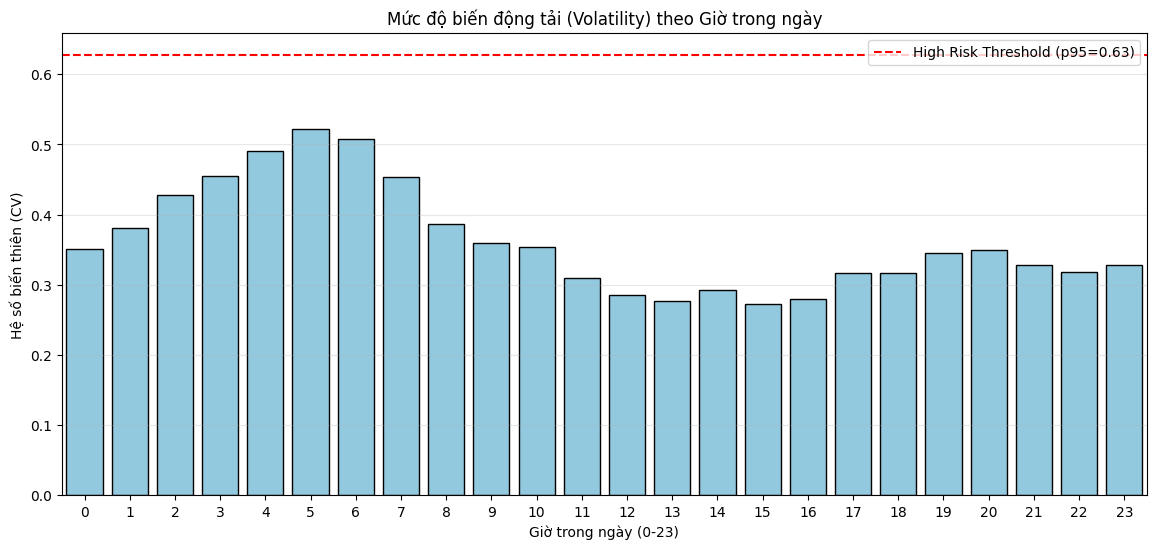

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_safety_thresholds(file_path):
    print(f"--- ĐANG PHÂN TÍCH DỮ LIỆU TỪ: {file_path} ---")
    
    # 1. Đọc dữ liệu
    df = pd.read_csv(file_path)
    
    # 2. Lọc dữ liệu sạch
    clean_df = df[(df['is_system_down'] == 0) & (df['rolling_mean_1h'].notna()) & (df['rolling_mean_1h'] > 0)].copy()
    
    # 3. Tính Hệ số biến thiên (Coefficient of Variation - CV)
    # CV = Độ lệch chuẩn / Trung bình. 
    # CV cho biết độ biến động tính theo % (Ví dụ CV=0.2 nghĩa là tải dao động +/- 20%)
    clean_df['volatility_cv'] = clean_df['rolling_std_1h'] / clean_df['rolling_mean_1h']
    
    # 4. Thống kê theo giờ (Hourly Profiling)
    # Gom nhóm theo giờ trong ngày để xem giờ nào "nguy hiểm" nhất
    hourly_stats = clean_df.groupby('hour_of_day')['volatility_cv'].agg(['mean', 'median', 'max']).reset_index()
    
    # 5. Tự động đề xuất Safety Factor (Quan trọng nhất)
    # Chúng ta lấy các mốc phân vị (Percentile) để ra quyết định
    p50 = clean_df['volatility_cv'].quantile(0.50) # Mức trung bình
    p75 = clean_df['volatility_cv'].quantile(0.75) # Mức hơi cao
    p95 = clean_df['volatility_cv'].quantile(0.95) # Mức cực đoan (chỉ 5% số trường hợp vượt qua mức này)
    
    print("\n--- KẾT QUẢ PHÂN TÍCH ĐỘ BIẾN ĐỘNG (CV) ---")
    print(f"1. Độ biến động trung bình (Median): {p50:.4f} (Tải dao động khoảng {p50*100:.1f}%)")
    print(f"2. Độ biến động cao (75th Percentile): {p75:.4f} (Tải dao động khoảng {p75*100:.1f}%)")
    print(f"3. Độ biến động cực đoan (95th Percentile): {p95:.4f} (Tải dao động khoảng {p95*100:.1f}%)")
    
    print("\n--- ĐỀ XUẤT NGƯỠNG AN TOÀN (SAFETY MARGIN RECOMMENDATION) ---")
    # Công thức đề xuất: Safety Factor = 1 + (CV * k)
    # Ta nhân thêm hệ số k=1.0 để đảm bảo an toàn sát sườn, hoặc k=1.2 để dư dả
    print(f"-> Chế độ TIẾT KIỆM (Eco Mode - Ban đêm): Nhân dự báo với {1 + p50:.2f}")
    print(f"-> Chế độ TIÊU CHUẨN (Standard Mode): Nhân dự báo với {1 + p75:.2f}")
    print(f"-> Chế độ AN TOÀN CAO (Panic Mode - Giờ cao điểm): Nhân dự báo với {1 + p95:.2f}")

    # 6. Vẽ biểu đồ để đưa vào báo cáo
    plt.figure(figsize=(14, 6))
    
    # Biểu đồ cột: Biến động trung bình theo giờ
    sns.barplot(data=hourly_stats, x='hour_of_day', y='mean', color='skyblue', edgecolor='black')
    # Vẽ đường line mức rủi ro cao (p95)
    plt.axhline(y=p95, color='red', linestyle='--', label=f'High Risk Threshold (p95={p95:.2f})')
    
    plt.title('Mức độ biến động tải (Volatility) theo Giờ trong ngày')
    plt.ylabel('Hệ số biến thiên (CV)')
    plt.xlabel('Giờ trong ngày (0-23)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return hourly_stats

# Thay đường dẫn tới file 1m.csv của bạn vào đây
stats = analyze_safety_thresholds('../../data/cleaned/data_1m.csv')

In [3]:
import pandas as pd
import numpy as np

def create_simulation_input(file_1m_path, file_15m_path):
    print("--- ĐANG TẠO DỮ LIỆU DỰ BÁO GIẢ LẬP (BASELINE) ---")
    
    # 1. Xử lý file 1M (Dùng cho Reactive / Safety Net)
    df_1m = pd.read_csv(file_1m_path)
    # Dự báo ngây thơ: Lấy trung bình 5 phút trước đó làm dự báo cho phút tiếp theo
    df_1m['forecast_load'] = df_1m['requests'].rolling(window=5).mean().shift(-1)
    # Fill NaN (những dòng đầu/cuối) bằng chính giá trị thực
    df_1m['forecast_load'] = df_1m['forecast_load'].fillna(df_1m['requests'])
    
    # 2. Xử lý file 15M (Dùng cho Predictive / Warm-up)
    df_15m = pd.read_csv(file_15m_path)
    # Dự báo ngây thơ: Lấy trung bình 3 phiên (45 phút) trước đó
    df_15m['forecast_load'] = df_15m['requests'].rolling(window=3).mean().shift(-1)
    df_15m['forecast_load'] = df_15m['forecast_load'].fillna(df_15m['requests'])
    
    # 3. Lưu lại
    df_1m.to_csv('../../output/simulation_input_1m.csv', index=False)
    df_15m.to_csv('../../output/simulation_input_15m.csv', index=False)
    
    print("-> Đã tạo xong: 'simulation_input_1m.csv' và 'simulation_input_15m.csv'")
    return df_1m, df_15m

# Chạy hàm này với đường dẫn file csv của bạn
create_simulation_input('../../data/cleaned/data_1m.csv', '../../data/cleaned/data_15m.csv')

--- ĐANG TẠO DỮ LIỆU DỰ BÁO GIẢ LẬP (BASELINE) ---
-> Đã tạo xong: 'simulation_input_1m.csv' và 'simulation_input_15m.csv'


(                       timestamp  requests    bytes  hosts  errors  \
 0      1995-07-01 00:00:00-04:00        42   608453     20       0   
 1      1995-07-01 00:01:00-04:00        61   910128     24       1   
 2      1995-07-01 00:02:00-04:00        57   628556     24       0   
 3      1995-07-01 00:03:00-04:00        71  1747389     26       0   
 4      1995-07-01 00:04:00-04:00        70  1383149     29       0   
 ...                          ...       ...      ...    ...     ...   
 89275  1995-08-31 23:55:00-04:00        30   525990     10       0   
 89276  1995-08-31 23:56:00-04:00        38   647567     13       0   
 89277  1995-08-31 23:57:00-04:00        16   342046      9       0   
 89278  1995-08-31 23:58:00-04:00        17   399564     11       0   
 89279  1995-08-31 23:59:00-04:00        22   400302     10       0   
 
        is_system_down  req_lag_1  req_lag_12  req_lag_288  rolling_mean_1h  \
 0                   0        0.0         0.0          0.0         

In [ ]:
import pandas as pd
import math

# --- 1. KHỐI LOGIC CỐT LÕI (PHẦN 1) ---
class CoreLogic:
    def __init__(self, server_capacity=200): # Giả định 1 server chịu được 200 requests
        self.capacity = server_capacity

    def get_safety_factor(self, hour):
        # ÁP DỤNG KẾT QUẢ EDA:
        # 02:00 - 07:00: Giờ biến động cực đoan (Panic)
        if 2 <= hour <= 7: 
            return 1.63   
        # 11:00 - 16:00: Giờ ổn định (Eco)
        elif 11 <= hour <= 16: 
            return 1.32 
        # Còn lại: Giờ tiêu chuẩn (Standard)
        else: 
            return 1.42                

    def calculate_raw_demand(self, current_load_1m, forecast_15m, hour):
        safety_factor = self.get_safety_factor(hour)
        
        # A. Predictive Scaling (Dựa trên dự báo xa - Warm up)
        # Logic: Chuẩn bị server cho tương lai
        demand_pred = math.ceil((forecast_15m * safety_factor) / self.capacity)
        
        # B. Reactive Scaling (Safety Net - Phản ứng nhanh)
        # Logic: Cứu hệ thống ngay lập tức nếu tải thực tế tăng vọt
        demand_react = math.ceil((current_load_1m * safety_factor) / self.capacity)
        
        # C. Chiến lược MAX VOTING: Lấy số lớn hơn để đảm bảo an toàn
        needed = max(demand_pred, demand_react)
        
        return max(1, needed), safety_factor, demand_pred, demand_react

# --- 2. SCRIPT CHẠY THỬ KIỂM CHỨNG ---
def run_test():
    try:
        # Đọc file dữ liệu giả lập (Baseline) bạn đã tạo ở bước trước
        df = pd.read_csv('../../output/simulation_input_1m.csv')
        
        # Lấy 10 dòng mẫu (ví dụ lấy từ dòng 100 để né những dòng đầu có thể bị NaN)
        # Hoặc lấy 10 dòng đầu tiên nếu dữ liệu đã đẹp
        sample_data = df.iloc[0:15] 
        
        # Khởi tạo Logic
        engine = CoreLogic(server_capacity=100) # Mình để capacity=100 cho dễ nhẩm tính
        
        print("\n" + "="*100)
        print(f"TEST PHẦN 1: LOGIC TÍNH TOÁN NHU CẦU (Capacity = {engine.capacity} req/server)")
        print("="*100)
        print(f"{'Time':<20} | {'Hour':<4} | {'Load(1m)':<8} | {'Fcst(15m)':<9} | {'Mode':<8} | {'Factor':<6} | {'Pred':<4} | {'React':<5} | {'FINAL'}")
        print("-" * 100)

        for index, row in sample_data.iterrows():
            # Lấy thông tin đầu vào
            timestamp = row['timestamp']
            hour = int(row['hour_of_day'])
            load_1m = row['requests']
            
            # Giả lập Forecast 15m: 
            # Trong thực tế bạn sẽ merge file 15m vào. 
            # Ở đây để test nhanh, mình lấy tạm cột forecast_load trong file 1m (đang là SMA 5p)
            # Hoặc giả lập nó lệch đi một chút để thấy sự khác biệt
            forecast_15m = row['forecast_load'] 

            # --- GỌI HÀM TÍNH TOÁN ---
            final_servers, factor, d_pred, d_react = engine.calculate_raw_demand(load_1m, forecast_15m, hour)
            
            # Xác định tên chế độ để in ra cho đẹp
            mode_name = "STD"
            if factor == 1.63: mode_name = "PANIC"
            if factor == 1.32: mode_name = "ECO"

            # In kết quả
            print(f"{timestamp:<20} | {hour:<4} | {load_1m:<8.1f} | {forecast_15m:<9.1f} | {mode_name:<8} | {factor:<6} | {d_pred:<4} | {d_react:<5} | {final_servers} servers")

        print("="*100)
        print("HƯỚNG DẪN KIỂM TRA:")
        print("1. Kiểm tra cột 'Factor': Giờ 02-07 phải là 1.63, Giờ 11-16 phải là 1.32.")
        print("2. Kiểm tra cột 'FINAL': Nó phải bằng MAX(Pred, React).")
        print("3. Kiểm tra tính toán: (Load * Factor) / 100 -> Làm tròn lên có đúng không?")

    except FileNotFoundError:
        print("LỖI: Không tìm thấy file 'simulation_input_1m.csv'. Hãy chạy code tạo dữ liệu giả lập ở bước trước!")
    except Exception as e:
        print(f"LỖI: {e}")

if __name__ == "__main__":
    run_test()


TEST PHẦN 1: LOGIC TÍNH TOÁN NHU CẦU (Capacity = 100 req/server)
Time                 | Hour | Load(1m) | Fcst(15m) | Mode     | Factor | Pred | React | FINAL
----------------------------------------------------------------------------------------------------
1995-07-01 00:00:00-04:00 | 0    | 42.0     | 42.0      | STD      | 1.42   | 1    | 1     | 1 servers
1995-07-01 00:01:00-04:00 | 0    | 61.0     | 61.0      | STD      | 1.42   | 1    | 1     | 1 servers
1995-07-01 00:02:00-04:00 | 0    | 57.0     | 57.0      | STD      | 1.42   | 1    | 1     | 1 servers
1995-07-01 00:03:00-04:00 | 0    | 71.0     | 60.2      | STD      | 1.42   | 1    | 2     | 2 servers
1995-07-01 00:04:00-04:00 | 0    | 70.0     | 62.6      | STD      | 1.42   | 1    | 1     | 1 servers
1995-07-01 00:05:00-04:00 | 0    | 54.0     | 60.8      | STD      | 1.42   | 1    | 1     | 1 servers
1995-07-01 00:06:00-04:00 | 0    | 52.0     | 63.0      | STD      | 1.42   | 1    | 1     | 1 servers
1995-07-01 00:07:0

In [6]:
import pandas as pd
import math
# from step1_core_logic import CoreLogic 
class CoreLogic:
    def __init__(self, server_capacity=200):
        self.capacity = server_capacity
    def get_safety_factor(self, hour):
        if 2 <= hour <= 7: return 1.63   
        elif 11 <= hour <= 16: return 1.32 
        else: return 1.42                
    def calculate_raw_demand(self, current_load_1m, forecast_15m, hour):
        safety_factor = self.get_safety_factor(hour)
        d_pred = math.ceil((forecast_15m * safety_factor) / self.capacity)
        d_react = math.ceil((current_load_1m * safety_factor) / self.capacity)
        return max(1, max(d_pred, d_react))

# --- PHẦN 2: LỚP ỔN ĐỊNH HÓA (STABILITY LAYER) ---
class StabilityEngine(CoreLogic):
    def __init__(self, capacity=100): # Lưu ý: Capacity khớp với bài test
        super().__init__(capacity)
        
        # TRẠNG THÁI HỆ THỐNG
        self.current_servers = 1
        self.last_scale_time = -999 # Thời điểm scale cuối cùng (phút)
        
        # CẤU HÌNH COOLDOWN (LUẬT BẤT ĐỐI XỨNG)
        self.COOLDOWN_SCALE_OUT = 1   # Tăng server: Chỉ cần đợi 1 phút (Phản ứng nhanh)
        self.COOLDOWN_SCALE_IN = 5    # Giảm server: Phải đợi 5 phút (Để tránh flapping)

    def decide_action(self, timestamp_minute, load_1m, forecast_15m, hour):
        # 1. Tính nhu cầu thô (Dùng logic Phần 1)
        raw_demand = self.calculate_raw_demand(load_1m, forecast_15m, hour)
        
        # 2. Logic Hysteresis & Cooldown
        minutes_since_last = timestamp_minute - self.last_scale_time
        action = "HOLD"
        
        # TRƯỜNG HỢP 1: MUỐN TĂNG SERVER (SCALE OUT)
        if raw_demand > self.current_servers:
            # Kiểm tra Cooldown
            if minutes_since_last >= self.COOLDOWN_SCALE_OUT:
                self.current_servers = raw_demand
                self.last_scale_time = timestamp_minute
                action = "SCALE_OUT ⬆️"
            else:
                action = "WAIT_UP ⏳" # Muốn tăng nhưng chưa hết cooldown

        # TRƯỜNG HỢP 2: MUỐN GIẢM SERVER (SCALE IN)
        elif raw_demand < self.current_servers:
            # Kiểm tra Cooldown (Khắt khe hơn)
            if minutes_since_last >= self.COOLDOWN_SCALE_IN:
                self.current_servers = raw_demand
                self.last_scale_time = timestamp_minute
                action = "SCALE_IN ⬇️"
            else:
                action = "WAIT_DOWN 🛡️" # Giữ nguyên để chống rung
        
        return self.current_servers, action, raw_demand

# --- SCRIPT TEST PHẦN 2 ---
def run_stability_test():
    df = pd.read_csv('../../output/simulation_input_1m.csv').iloc[0:20] # Lấy 20 dòng để thấy rõ cooldown
    engine = StabilityEngine(capacity=100)
    
    print("\n" + "="*110)
    print("TEST PHẦN 2: CƠ CHẾ CHỐNG RUNG (COOLDOWN: UP=1m, DOWN=5m)")
    print("="*110)
    print(f"{'Time':<5} | {'Raw':<3} | {'Curr':<4} | {'Action':<15} | {'Note'}")
    print("-" * 110)
    
    # Biến đếm thời gian giả lập (phút 0, 1, 2...)
    sim_minute = 0
    
    for index, row in df.iterrows():
        # Gọi hàm quyết định
        final_sv, act, raw = engine.decide_action(sim_minute, row['requests'], row['forecast_load'], row['hour_of_day'])
        
        # Logic tạo ghi chú để bạn dễ hiểu
        note = ""
        if act == "SCALE_OUT ⬆️": note = "Tăng ngay để cứu hệ thống"
        if act == "WAIT_DOWN 🛡️": note = f"Nhu cầu giảm còn {raw}, nhưng giữ {final_sv} do cooldown"
        if act == "SCALE_IN ⬇️": note = "Hết cooldown, cho phép giảm tiết kiệm tiền"

        print(f"{sim_minute:<5} | {raw:<3} | {final_sv:<4} | {act:<15} | {note}")
        sim_minute += 1 # Tăng thời gian lên 1 phút

if __name__ == "__main__":
    run_stability_test()


TEST PHẦN 2: CƠ CHẾ CHỐNG RUNG (COOLDOWN: UP=1m, DOWN=5m)
Time  | Raw | Curr | Action          | Note
--------------------------------------------------------------------------------------------------------------
0     | 1   | 1    | HOLD            | 
1     | 1   | 1    | HOLD            | 
2     | 1   | 1    | HOLD            | 
3     | 2   | 2    | SCALE_OUT ⬆️    | Tăng ngay để cứu hệ thống
4     | 1   | 2    | WAIT_DOWN 🛡️    | Nhu cầu giảm còn 1, nhưng giữ 2 do cooldown
5     | 1   | 2    | WAIT_DOWN 🛡️    | Nhu cầu giảm còn 1, nhưng giữ 2 do cooldown
6     | 1   | 2    | WAIT_DOWN 🛡️    | Nhu cầu giảm còn 1, nhưng giữ 2 do cooldown
7     | 1   | 2    | WAIT_DOWN 🛡️    | Nhu cầu giảm còn 1, nhưng giữ 2 do cooldown
8     | 1   | 1    | SCALE_IN ⬇️     | Hết cooldown, cho phép giảm tiết kiệm tiền
9     | 1   | 1    | HOLD            | 
10    | 1   | 1    | HOLD            | 
11    | 2   | 2    | SCALE_OUT ⬆️    | Tăng ngay để cứu hệ thống
12    | 1   | 2    | WAIT_DOWN 🛡️    | Nhu

In [8]:
import pandas as pd
import math

# --- LOGIC CỐT LÕI (PHẦN 1 & 2 GỘP LẠI) ---
class BaseAutoScaler:
    def __init__(self, capacity=100):
        self.capacity = capacity
        self.current_servers = 1
        self.last_scale_time = -999
        self.COOLDOWN_SCALE_OUT = 1
        self.COOLDOWN_SCALE_IN = 15 # 15 phút cho thực tế (Test để 5, chạy thật nên để 15)

    def get_safety_factor(self, hour):
        if 2 <= hour <= 7: return 1.63   
        elif 11 <= hour <= 16: return 1.32 
        else: return 1.42 

# --- PHẦN 3: ENGINE HOÀN CHỈNH (FINAL SYSTEM) ---
class FinalEngine(BaseAutoScaler):
    def __init__(self, capacity=100, unit_cost=0.1, sla_penalty=5.0):
        super().__init__(capacity)
        self.unit_cost = unit_cost       # Giá $0.1 / server / giờ
        self.sla_penalty = sla_penalty   # Phạt $5.0 cho mỗi request bị rớt (SLA Breach)

    def detect_ddos(self, current_load, forecast):
        # QUY TẮC: Nếu tải thực gấp 5 lần dự báo -> Nghi vấn DDoS
        if forecast > 10 and current_load > forecast * 5:
            return True
        return False

    def run_step(self, timestamp, current_load, forecast, hour):
        # 1. Tầng Anomaly Detection
        is_ddos = self.detect_ddos(current_load, forecast)
        
        # 2. Tầng Tính toán Nhu cầu (Core Logic)
        safety_factor = self.get_safety_factor(hour)
        
        # Nếu DDoS: Cap lại, không cho scale quá 50 server để bảo vệ ví tiền
        # Nếu Bình thường: Tính toán như Phần 1
        if is_ddos:
            raw_demand = min(50, math.ceil(current_load / self.capacity)) 
            safety_factor = 1.0 # Không nhân hệ số an toàn khi đang bị tấn công
        else:
            d_pred = math.ceil((forecast * safety_factor) / self.capacity)
            d_react = math.ceil((current_load * safety_factor) / self.capacity)
            raw_demand = max(d_pred, d_react)
            # Circuit Breaker: Giới hạn tối đa (ví dụ 1000 server) để tránh bug vô hạn
            raw_demand = min(raw_demand, 1000)

        # 3. Tầng Ổn định (Stability Logic)
        minutes_since = timestamp - self.last_scale_time
        action = "HOLD"
        
        # Scale OUT
        if raw_demand > self.current_servers:
            if minutes_since >= self.COOLDOWN_SCALE_OUT:
                self.current_servers = raw_demand
                self.last_scale_time = timestamp
                action = "SCALE_OUT"
            else:
                action = "WAIT_UP"
        
        # Scale IN
        elif raw_demand < self.current_servers:
            if minutes_since >= self.COOLDOWN_SCALE_IN:
                self.current_servers = raw_demand
                self.last_scale_time = timestamp
                action = "SCALE_IN"
            else:
                action = "WAIT_DOWN"

        # 4. Tầng Tài chính (Cost Analysis)
        real_capacity = self.current_servers * self.capacity
        dropped_req = max(0, current_load - real_capacity)
        
        # Tính chi phí cho phút này (Chia 60 vì unit_cost là theo giờ)
        cost_infra = (self.current_servers * self.unit_cost) / 60
        cost_sla = dropped_req * self.sla_penalty
        total_cost = cost_infra + cost_sla

        return {
            "timestamp": timestamp,
            "load": current_load,
            "servers": self.current_servers,
            "capacity": real_capacity,
            "action": action,
            "is_ddos": is_ddos,
            "dropped": dropped_req,
            "cost_infra": cost_infra,
            "cost_sla": cost_sla,
            "total_cost": total_cost
        }

# --- CHẠY MÔ PHỎNG TOÀN BỘ DỮ LIỆU ---
def run_full_simulation():
    print("⏳ Đang load dữ liệu toàn bộ...")
    # Load file 1m mà bạn đã tạo ở Bước 2 (Simulation Input)
    df = pd.read_csv('../../output/simulation_input_1m.csv')
    
    # Khởi tạo Engine
    engine = FinalEngine(capacity=100, unit_cost=0.1, sla_penalty=5.0)
    
    results = []
    print("🚀 Bắt đầu chạy mô phỏng Final Engine...")
    
    # Giả lập biến thời gian chạy từ 0
    sim_time = 0
    
    for index, row in df.iterrows():
        # Gọi engine cho từng phút
        res = engine.run_step(
            timestamp=sim_time,
            current_load=row['requests'],
            forecast=row['forecast_load'], # Dùng cột forecast (SMA) đã tạo
            hour=row['hour_of_day']
        )
        # Thêm timestamp thực tế để dễ tracking
        res['real_time'] = row['timestamp']
        results.append(res)
        sim_time += 1
        
    # Xuất kết quả ra CSV
    result_df = pd.DataFrame(results)
    output_filename = '../../output/final_simulation_report.csv'
    result_df.to_csv(output_filename, index=False)
    
    print("\n" + "="*80)
    print("KẾT QUẢ TỔNG HỢP CHIẾN LƯỢC CỦA BẠN")
    print("="*80)
    print(f"Tổng thời gian chạy: {len(result_df)} phút")
    print(f"Tổng chi phí Server (Infrastructure): ${result_df['cost_infra'].sum():,.2f}")
    print(f"Tổng tiền phạt SLA (Penalty):         ${result_df['cost_sla'].sum():,.2f}")
    print(f"-> TỔNG CHI PHÍ CUỐI CÙNG:            ${result_df['total_cost'].sum():,.2f}")
    print("-" * 80)
    print(f"Số lần phát hiện DDoS giả định:       {result_df['is_ddos'].sum()}")
    print(f"Số request bị rớt (Dropped):          {result_df['dropped'].sum()}")
    print("="*80)
    print(f"✅ Đã lưu chi tiết vào file: {output_filename}")
    print("Bạn có thể dùng file này để vẽ biểu đồ báo cáo!")

if __name__ == "__main__":
    run_full_simulation()

⏳ Đang load dữ liệu toàn bộ...
🚀 Bắt đầu chạy mô phỏng Final Engine...

KẾT QUẢ TỔNG HỢP CHIẾN LƯỢC CỦA BẠN
Tổng thời gian chạy: 89280 phút
Tổng chi phí Server (Infrastructure): $183.18
Tổng tiền phạt SLA (Penalty):         $0.00
-> TỔNG CHI PHÍ CUỐI CÙNG:            $183.18
--------------------------------------------------------------------------------
Số lần phát hiện DDoS giả định:       0
Số request bị rớt (Dropped):          0
✅ Đã lưu chi tiết vào file: ../../output/final_simulation_report.csv
Bạn có thể dùng file này để vẽ biểu đồ báo cáo!


In [9]:
def calculate_savings_comparison():
    # 1. Đọc lại file kết quả
    df = pd.read_csv('../../output/final_simulation_report.csv')
    
    # 2. Chiến lược TĨNH (FIXED STRATEGY)
    # Nguyên lý: Để không bao giờ sập, người ta phải bật số server chịu được tải CAO NHẤT từng xuất hiện
    max_load = df['load'].max()
    capacity_per_server = 100 # (Khớp với capacity trong class FinalEngine)
    
    # Số server cố định cần bật 24/7
    fixed_servers_needed = math.ceil(max_load / capacity_per_server)
    
    # Tính tiền: Số server * Giá * Tổng thời gian (giờ)
    total_hours = len(df) / 60
    unit_cost = 0.1 # Khớp với unit_cost của bạn
    
    fixed_cost = fixed_servers_needed * unit_cost * total_hours
    
    # 3. So sánh với chiến lược của BẠN (AUTOSCALING)
    my_cost = df['total_cost'].sum() # $183.18
    
    saved_amount = fixed_cost - my_cost
    saved_percent = (saved_amount / fixed_cost) * 100
    
    print("\n" + "="*60)
    print("SO SÁNH HIỆU QUẢ KINH TẾ (COST BENEFIT ANALYSIS)")
    print("="*60)
    print(f"1. Chiến lược Truyền thống (Fixed {fixed_servers_needed} Servers): ${fixed_cost:,.2f}")
    print(f"2. Chiến lược Autoscaling của bạn:           ${my_cost:,.2f}")
    print("-" * 60)
    print(f"-> BẠN ĐÃ TIẾT KIỆM ĐƯỢC:  ${saved_amount:,.2f} ({saved_percent:.2f}%)")
    print("="*60)

# Chạy hàm này ngay
import math
import pandas as pd
calculate_savings_comparison()


SO SÁNH HIỆU QUẢ KINH TẾ (COST BENEFIT ANALYSIS)
1. Chiến lược Truyền thống (Fixed 5 Servers): $744.00
2. Chiến lược Autoscaling của bạn:           $183.18
------------------------------------------------------------
-> BẠN ĐÃ TIẾT KIỆM ĐƯỢC:  $560.82 (75.38%)
